In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import math
from matplotlib.collections import PatchCollection

In [3]:
info = pd.read_csv("data/env_info.csv")
#info['num_of_birds'][0]

## Episodes learning

In [4]:
#TODO: output a file with general info about the simulation so that we know the number of birds considered a priori
#plt.style.available
plt.style.use('ggplot')

def plot_episode():
    info = pd.read_csv("data/env_info.csv")
    num_birds=info['num_of_birds'][0]
    episode_lenght=info['episodes_length'][0]
    df = pd.read_csv("data/episode.csv")
    df["NormEndTime"] = df["EndTime"] / episode_lenght
    df["mean_norm_end"] = df["NormEndTime"] .rolling(100, min_periods=5).mean()
    #print(df)
    pred_train = df["PredatorTraining"]
    learner_change = np.where(np.roll(pred_train, -1) != pred_train)[0]
    ax = df.plot(x="Episode", y="mean_norm_end", kind="line", lw=0.5, legend=False, figsize=(16,9))
    ax.set_ylabel("EndTime")
    for i, x_l in enumerate(learner_change):
        if i%2 == 0:
            ax.axvline(x=x_l, color="red", linestyle='--', lw=1)
        else:
            ax.axvline(x=x_l, color="blue", linestyle='--', lw=1)

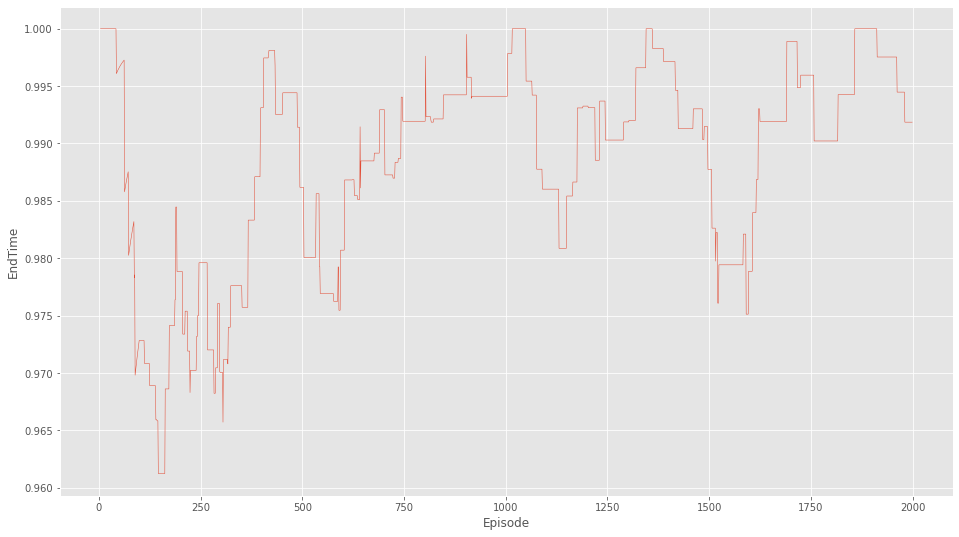

In [5]:
plot_episode()

## New processing

In [22]:
def preprocessing():
    df = pd.read_csv("data/value_policy.csv")
    df_aux = pd.read_csv("data/episode.csv")
    episodes = len(df_aux)
    states = len(df)*1000//episodes
    df["State"] = [ i%states for i in range(episodes*states//1000)]
    df["Episode"] = [i//states for i in range(episodes*states//1000)]
    index = ['Episode', 'State']
    df.set_index(index, inplace=True)
    #df = df.loc[(slice(None),[0,1,2,4,8,16]),:]
    return df

def softmax(a):
    a = a - np.mean(a, axis=1, keepdims=True)
    a = np.exp(a)
    return a / np.sum(a, axis=1, keepdims=True)

#Extract policy
def extract_policy(df, cols):
    d = df[cols]
    d = d.unstack("State")
    #Softmax
    m = d.mean(axis=1, level=1)
    d = d.subtract(m,axis=0)
    d = d.apply(np.exp)
    s = d.sum(axis=1, level=1)
    d = d.divide(s,axis=0)
    return d

def extract_value(df, col):
    d = df[col]
    d = d.unstack("State")
    return d

In [34]:
df = preprocessing()
df = extract_value(df, "value_1")
df.plot()

NameError: name 'preprocessing' is not defined

In [ ]:
df = preprocessing()
df = extract_value(df, "value_1")
df.plot()